# Effects of Domain in the GM Model

By keeping all paramters constant and initial conditions consistent as random numbers in the activator component matrix (modeled by U in the GM model), we visualized the evolution of pattern with ADI method for different domains.

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Experiments Parameters Setup

### Varied Domain 
```python
Ny_list = [4, 6, 8, 10, 14, 18, 25, 32, 40] # varied length of the y-direction of the grid
```
### Other Controled Conditions
```python
Nx = 40 # length of the x-direction side of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 0.02 # diffusion rate of u
Dv = 2 # diffusion rate of v
rho = 0.001 # source density
rho_u = 0.001 # basic activator production rate
mu_u = 0.02 # decay rate of u
mu_v = 0.03 # decay rate of v
kappa = 0.1 # saturation constanct

dt = 20 # time step size for ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution

U_init = np.random.normal(0.5, 0.1, (Ny, Nx)) # initial condition for u: random normal (mean=0.5, std=0.1)
V_init = 0.1 * np.ones((Ny, Nx)) # initial condition for v: all 0.1
```

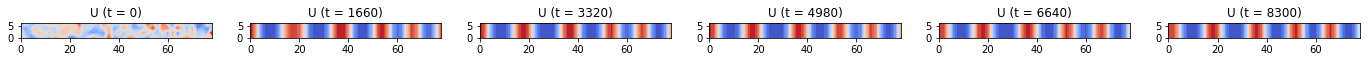

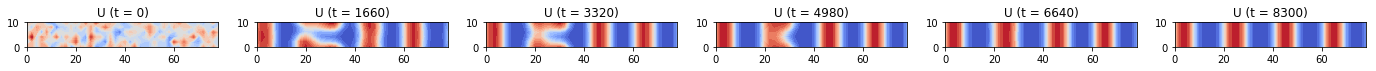

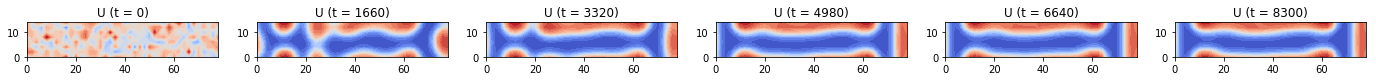

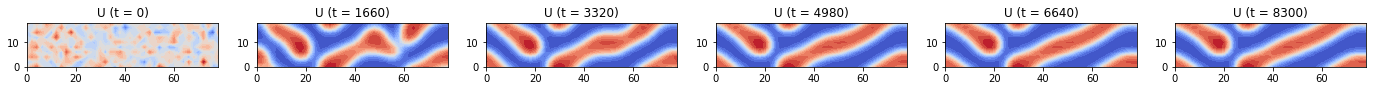

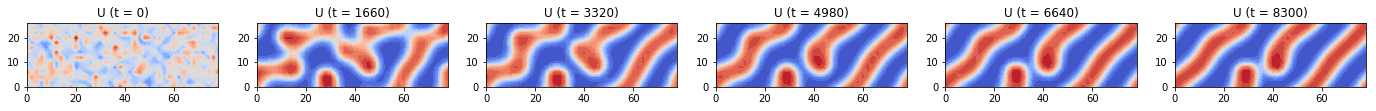

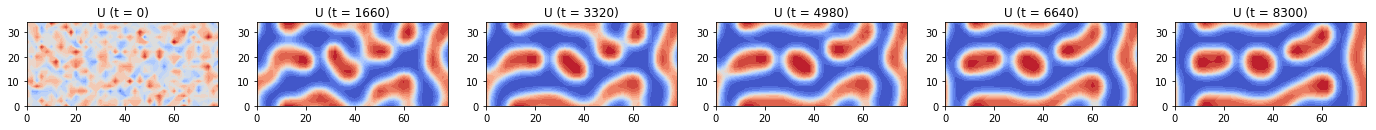

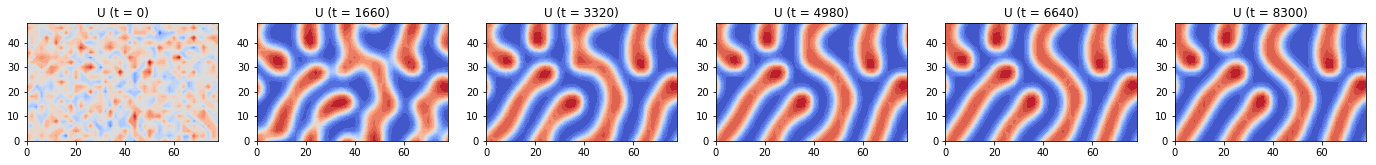

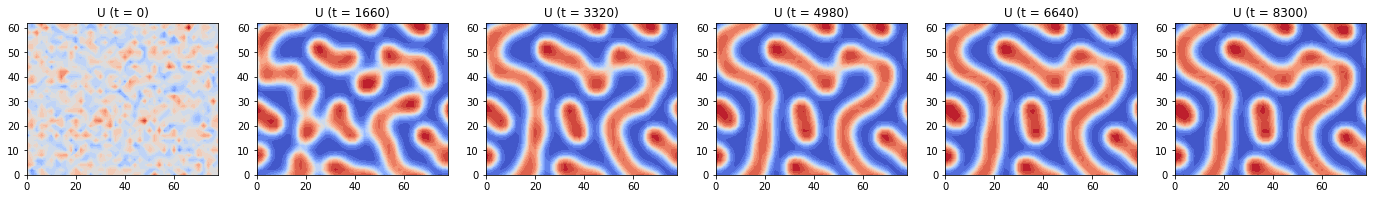

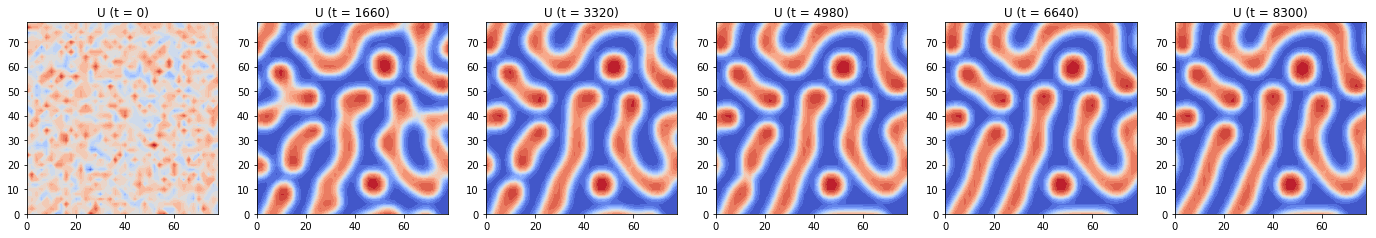

In [2]:
# Grid setup
Ny_list = [4, 6, 8, 10, 14, 18, 25, 32, 40]
Nx = 40
h = 2

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

for Ny in Ny_list:
    N = Nx * Ny
    
    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())

    # Initial condition
    U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
    V_init = 0.1 * np.ones((Ny, Nx))

    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
            + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
            + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)

    plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)


## Summary
As visualized above, as we increase the length of the y-direction side of the gird, we saw patterns modeled by the GM model's activator component (U) as 

- vertical stripes against the x-direction,
- approximately parallel stripes against the x-direction, 
- a combination of spots short-length stripes, 
- and more complicated combination of spots and stripes. 

This corresponds to Murray's claim on the pattern of animal tails that **narrow domains** allow only bands to grow while **large domains** allow spots or more complicated pattern to form.